In [89]:
# !pip install Tensorflow
# !pip install Keras
# !pip install scikit-learn
# !pip install imblearn
# !pip install scikeras
# !pip install gensim


In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.utils import set_random_seed
from tensorflow.data import Dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
import os
import zipfile

In [91]:
set_random_seed(8)

## Importing the data

In [92]:
df = pd.read_csv('data/processed_data.csv', index_col =0)
df

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails congress falling short g...,0
2,eat veggies deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word streaming...,1
...,...,...
28614,jews celebrate rosh hashasha something,1
28615,internal affairs investigator disappointed con...,1
28616,beautiful acceptance speech week came queer ko...,0
28617,mars probe destroyed orbiting spielberggates s...,1


In [93]:
df.isna().sum()

headline        2
is_sarcastic    0
dtype: int64

In [94]:
df.dropna(inplace = True)

In [95]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [96]:
df.shape

(28615, 2)

## Splitting data

In [97]:
X = df["headline"]
y = df["is_sarcastic"]

splitting data 70\% train, 10\% validation, 20\% test

In [98]:
#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, random_state = 8)

#splitting the (training) data into training and validating data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.125, random_state = 8)

In [99]:
X_train.sample(5)

11248                 promotional pen covered deadly virus
7318            incredibly boring trait great leaders need
4803         kfc midas team muchanticipated crossover meal
17606        stolen moment week brett davis sally burtnick
21592    race relations forgetting ferguson remembering...
Name: headline, dtype: object

In [100]:
y_train.sample(5)

22619    0
19821    1
3560     0
22091    1
11353    0
Name: is_sarcastic, dtype: int64

## Model statistics

In [101]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

In [102]:


def printModelStats(model, X, y):

    y_pred = model.predict(X)
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1    


    print(classification_report(y, y_pred, target_names = ['Sarcastic', 'Not Sarcastic']))
   
    cm = confusion_matrix(y, y_pred)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

## Tokenizing

In [103]:
tokenizer = Tokenizer(oov_token="<OOV>")

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#choosing max length to be 20, which is is more than 2*STD +- mean number of words per headline
max_length = 20 # max([len(sentence.split()) for sentence in X_train])

X_train_untk = X_train

In [104]:
#tokenizing headlines
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_length, padding = "post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_length, padding = "post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_length, padding = "post")

In [105]:
vocab_size = len(tokenizer.word_index)+1
print(f'The size of vocabulary: {vocab_size}')

The size of vocabulary: 24122


## Simple bidirectional GRU

With own embedding

In [106]:
output_dimension = 100


model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length))
model.add((GRU(32)))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 20, 100)           2412200   
                                                                 
 gru_18 (GRU)                (None, 32)                12864     
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 64)                2112      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2427241 (9.26 MB)
Trainable params: 242

In [107]:

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [108]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


In [109]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/5


626/626 [==============================] - 24s 35ms/step - loss: 0.6815 - accuracy: 0.5379 - val_loss: 0.5123 - val_accuracy: 0.7477
Epoch 2/5
626/626 [==============================] - 18s 28ms/step - loss: 0.4172 - accuracy: 0.8182 - val_loss: 0.4051 - val_accuracy: 0.8166
Epoch 3/5
626/626 [==============================] - 23s 36ms/step - loss: 0.1879 - accuracy: 0.9309 - val_loss: 0.4803 - val_accuracy: 0.8117
Epoch 4/5
626/626 [==============================] - 16s 26ms/step - loss: 0.0713 - accuracy: 0.9775 - val_loss: 0.6559 - val_accuracy: 0.8019
Epoch 4: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_12720\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


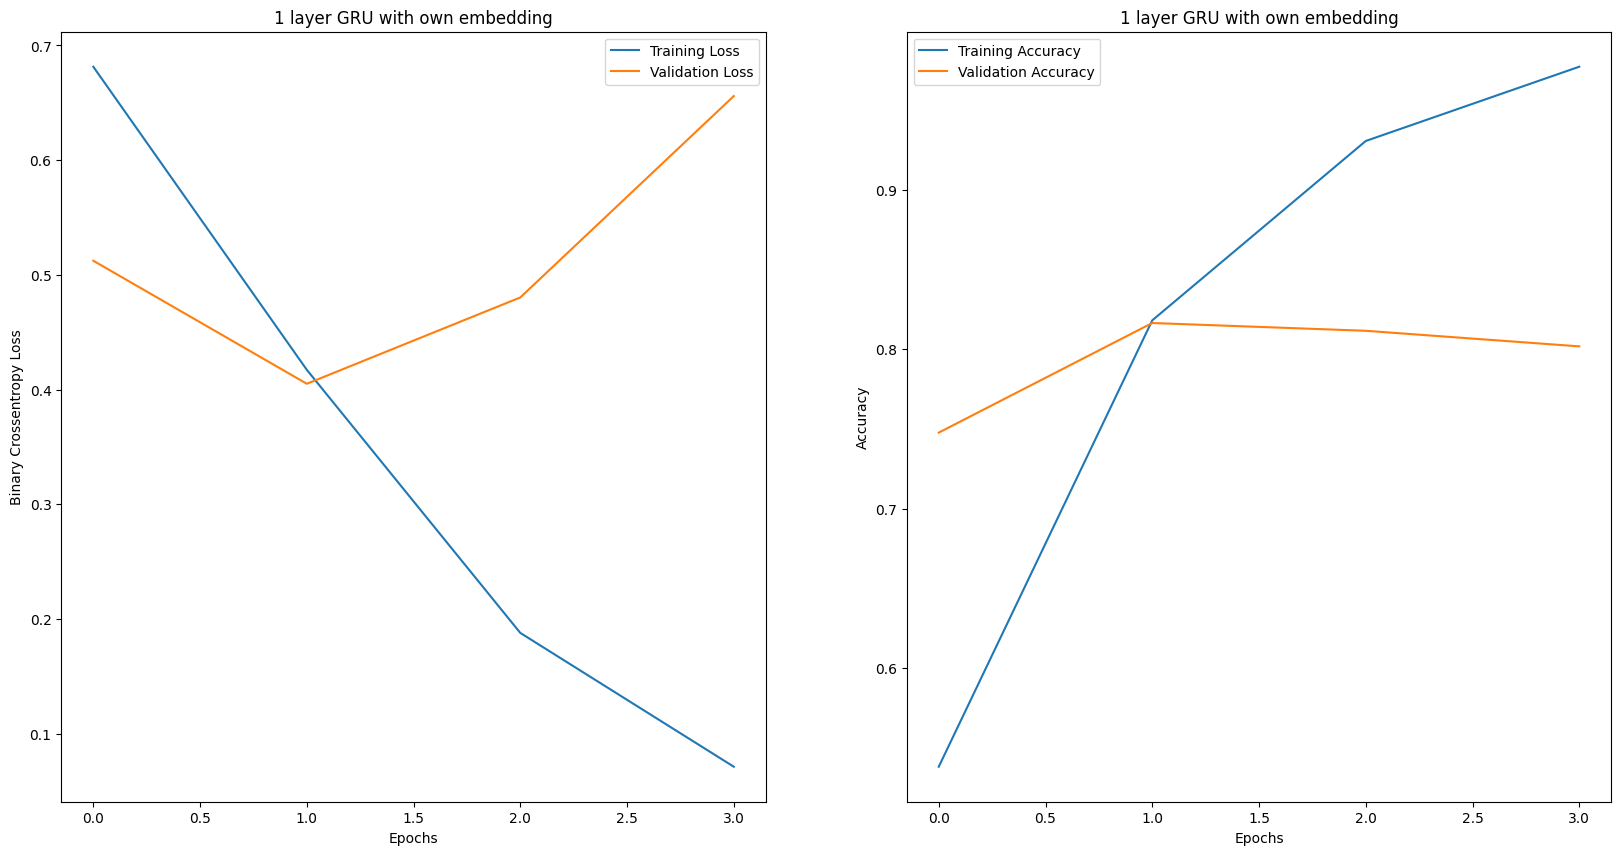

In [110]:
plotCurves(history, "1 layer GRU with own embedding")

printModelStats(model)

90/90 [==============================] - 1s 5ms/step
               precision    recall  f1-score   support

    Sarcastic       0.84      0.79      0.82      1475
Not Sarcastic       0.79      0.84      0.82      1387

     accuracy                           0.82      2862
    macro avg       0.82      0.82      0.82      2862
 weighted avg       0.82      0.82      0.82      2862

The confusion matrix:
[[1166  309]
 [ 216 1171]]


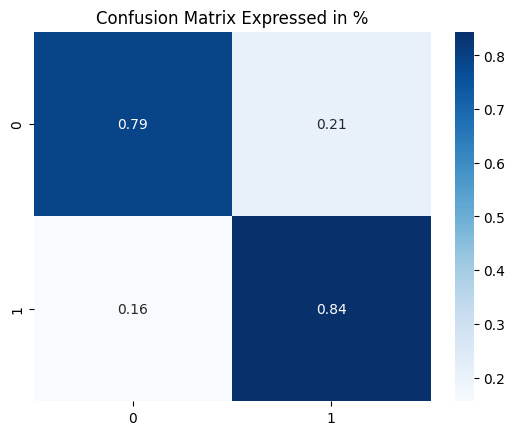

In [111]:
printModelStats(model, X_val, y_val)

## GRU with Word2Vec Embedding

In [112]:
output_dimension = 100


#Training Word2Vec embedding layer using Skip grams
sentences = [sentence.split() for sentence in X_train_untk]
w2v = Word2Vec(sentences, vector_size = output_dimension, sg=1)

#Creating the embedding weight matrix
embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]



In [113]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights= [embedding_matrix]))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 20, 100)           2412200   
                                                                 
 gru_19 (GRU)                (None, 32)                12864     
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                2112      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2427241 (9.26 MB)
Trainable params: 242

In [114]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [115]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/5
313/313 [==============================] - 15s 32ms/step - loss: 0.6020 - accuracy: 0.6506 - val_loss: 0.4284 - val_accuracy: 0.8054
Epoch 2/5
313/313 [==============================] - 12s 38ms/step - loss: 0.3252 - accuracy: 0.8703 - val_loss: 0.4281 - val_accuracy: 0.8155
Epoch 3/5
313/313 [==============================] - 11s 36ms/step - loss: 0.1325 - accuracy: 0.9546 - val_loss: 0.5443 - val_accuracy: 0.7980
Epoch 4/5
313/313 [==============================] - 10s 33ms/step - loss: 0.0618 - accuracy: 0.9791 - val_loss: 0.7437 - val_accuracy: 0.7921
Epoch 4: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_12720\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


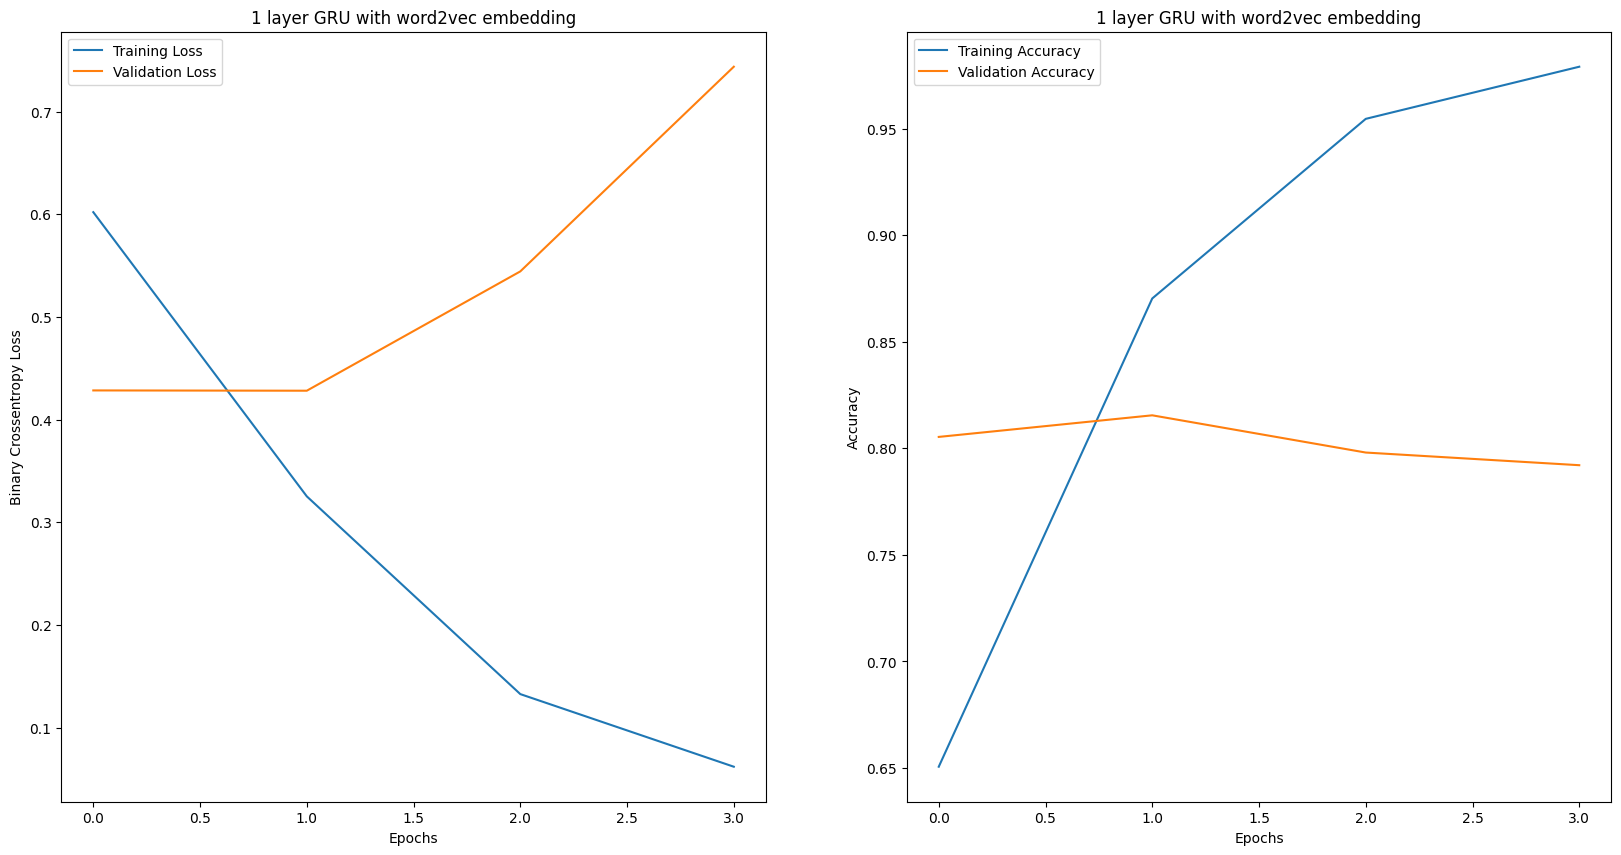

In [116]:
plotCurves(history, "1 layer GRU with word2vec embedding")

90/90 [==============================] - 1s 4ms/step
               precision    recall  f1-score   support

    Sarcastic       0.87      0.76      0.81      1475
Not Sarcastic       0.77      0.88      0.82      1387

     accuracy                           0.82      2862
    macro avg       0.82      0.82      0.82      2862
 weighted avg       0.82      0.82      0.82      2862

The confusion matrix:
[[1118  357]
 [ 171 1216]]


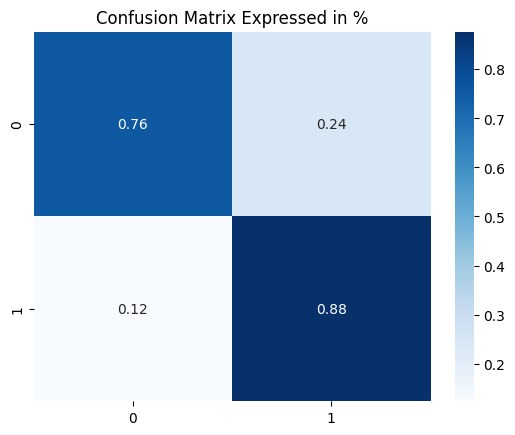

In [117]:
printModelStats(model, X_val, y_val)


## With glove embedding

In [119]:

from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
     
    #trying to find word in glove model
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]



In [120]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights= [embedding_matrix]))
model.add((GRU(32)))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 20, 100)           2412200   
                                                                 
 gru_20 (GRU)                (None, 32)                12864     
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                2112      
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2427241 (9.26 MB)
Trainable params: 242

In [121]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [122]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/5
313/313 [==============================] - 12s 31ms/step - loss: 0.5944 - accuracy: 0.6640 - val_loss: 0.4439 - val_accuracy: 0.8033
Epoch 2/5
313/313 [==============================] - 9s 30ms/step - loss: 0.3704 - accuracy: 0.8430 - val_loss: 0.3982 - val_accuracy: 0.8215
Epoch 3/5
313/313 [==============================] - 9s 29ms/step - loss: 0.2295 - accuracy: 0.9109 - val_loss: 0.4346 - val_accuracy: 0.8092
Epoch 4/5
313/313 [==============================] - 9s 29ms/step - loss: 0.1356 - accuracy: 0.9539 - val_loss: 0.4868 - val_accuracy: 0.8152
Epoch 4: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_12720\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


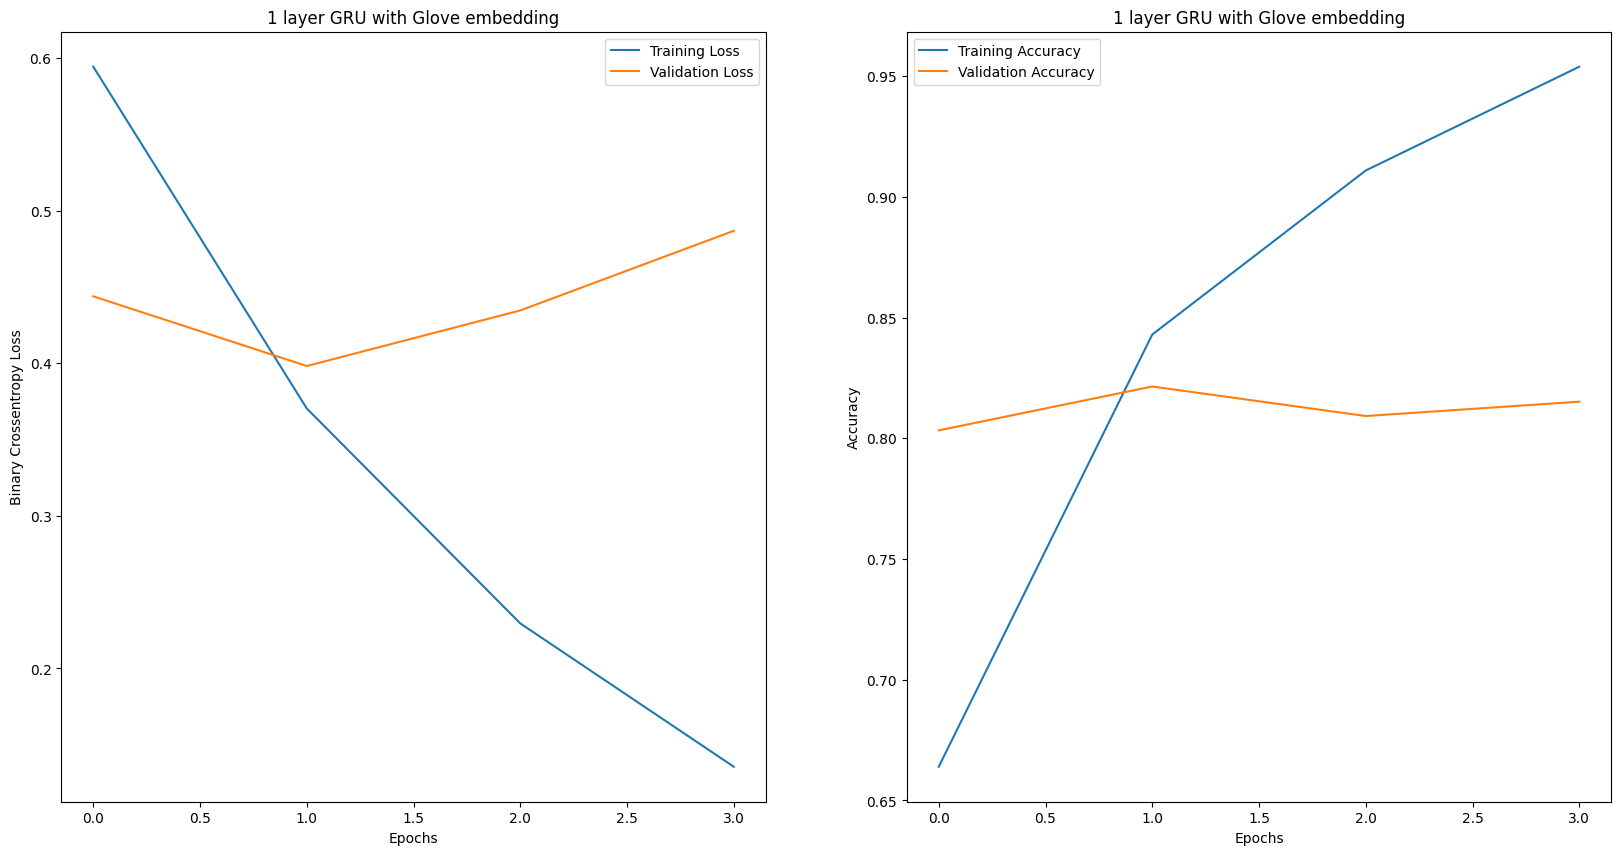

In [123]:
plotCurves(history, "1 layer GRU with Glove embedding")

90/90 [==============================] - 1s 4ms/step
               precision    recall  f1-score   support

    Sarcastic       0.84      0.81      0.82      1475
Not Sarcastic       0.80      0.84      0.82      1387

     accuracy                           0.82      2862
    macro avg       0.82      0.82      0.82      2862
 weighted avg       0.82      0.82      0.82      2862

The confusion matrix:
[[1190  285]
 [ 226 1161]]


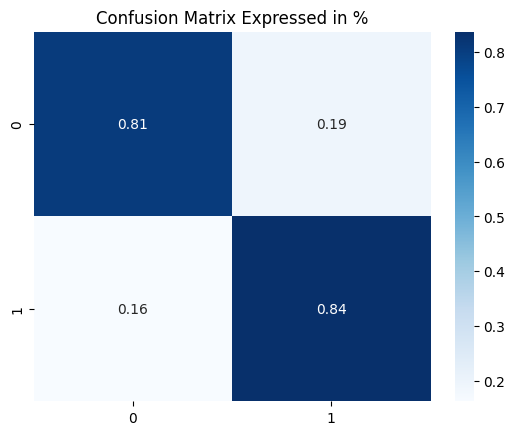

In [124]:
printModelStats(model, X_val, y_val)